In [27]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [28]:
import os
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [29]:
# DataPath = "/content/drive/MyDrive/Colab Notebooks/code brain tumor /masks_dataset"
DataPath = "/content/drive/MyDrive/masks_dataset"

dirs = []
images = []
masks = []
for dirname, _, filenames in os.walk(DataPath):
    for filename in filenames:
        if 'mask'in filename:
            dirs.append(dirname.replace(DataPath, ''))
            masks.append(filename)
            images.append(filename.replace('_mask', ''))

In [30]:
list = os.listdir("/content/drive/MyDrive/masks_dataset") # dir is your directory path
number_files = len(list)
print (number_files)

6000


In [31]:
len(dirs), len(images), len(masks)

(3000, 3000, 3000)

In [32]:
imagePath_df = pd.DataFrame({'directory':dirs, 'images': images, 'masks': masks})

In [33]:
imagePath_df.head()

,directory,images,masks
0,,no471.jpg,no471_mask.jpg
1,,no89.jpg,no89_mask.jpg
2,,y1323.jpg,y1323_mask.jpg
3,,no1033.jpg,no1033_mask.jpg
4,,y1353.jpg,y1353_mask.jpg


In [34]:
def print_imShape():
  
  idx = np.random.randint(0, len(imagePath_df))
    
  imagePath = os.path.join(DataPath, imagePath_df['directory'].iloc[idx], imagePath_df['images'].iloc[idx])
  maskPath = os.path.join(DataPath, imagePath_df['directory'].iloc[idx], imagePath_df['masks'].iloc[idx])
    
  image = cv2.imread(imagePath)
  mask = cv2.imread(maskPath)
    
  print(image.shape, mask.shape)

In [35]:
def plot_images():
    idx = np.random.randint(0, len(imagePath_df))
    
    imagePath = os.path.join(DataPath, imagePath_df['directory'].iloc[idx], imagePath_df['images'].iloc[idx])
    maskPath = os.path.join(DataPath, imagePath_df['directory'].iloc[idx], imagePath_df['masks'].iloc[idx])
    
    image = cv2.imread(imagePath)
    mask = cv2.imread(maskPath)
    
    fig, axs = plt.subplots(1,3, figsize=[13,15])
    
    axs[0].imshow(image)
    axs[0].set_title('Brain MRI')
    
    axs[1].imshow(mask)
    axs[1].set_title('Mask')
    
    axs[2].imshow(image)
    axs[2].imshow(mask, alpha=0.3)
    axs[2].set_title('MRI with mask')
    
    plt.grid(False)
    plt.show()

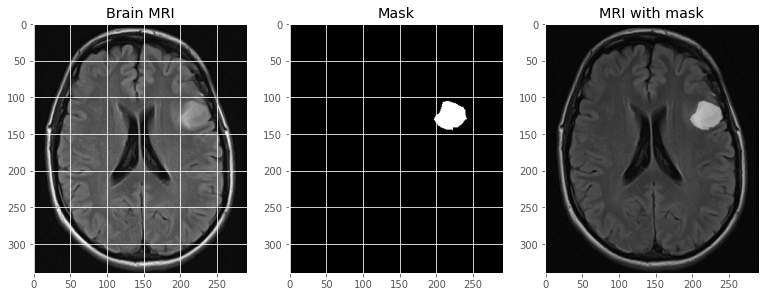

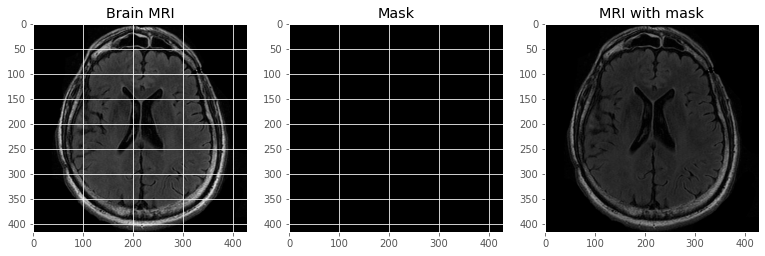

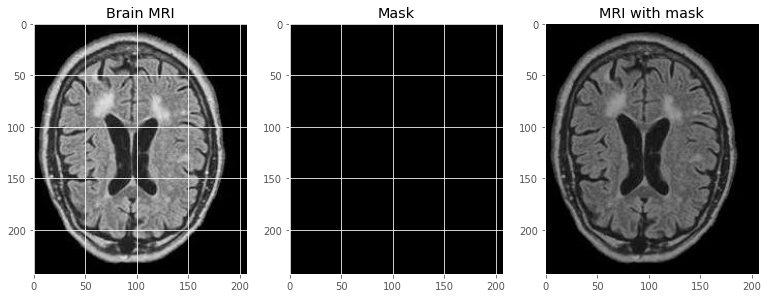

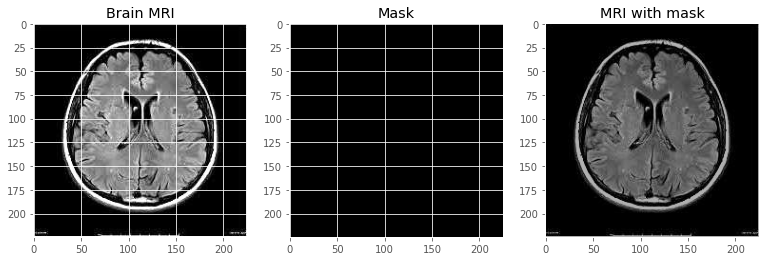

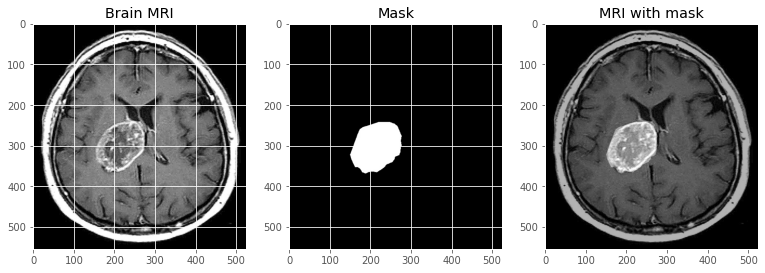

In [36]:
for i in range(5):
    plot_images()

In [37]:
imagePath_df['image-path'] = DataPath + imagePath_df['directory'] + '/' + imagePath_df['images']
imagePath_df['mask-path'] = DataPath + imagePath_df['directory'] + '/' + imagePath_df['masks'] 

In [38]:
train , test = train_test_split(imagePath_df, test_size=0.25, random_state=21)

In [39]:
EPOCHS = 35
BATCH_SIZE = 32
ImgHieght = 256
ImgWidth = 256
Channels = 3

In [40]:
data_augmentation = dict(rotation_range=0.2,
                        width_shift_range=0.05,
                        height_shift_range=0.05,
                        shear_range=0.05,
                        zoom_range=0.05,
                        horizontal_flip=True,
                        fill_mode='nearest')

In [41]:
# image generator
imagegen = ImageDataGenerator(rescale=1./255., **data_augmentation)
maskgen = ImageDataGenerator(rescale=1./255., **data_augmentation)


# train generator
timage_generator=imagegen.flow_from_dataframe(dataframe=train,
                                            x_col="image-path",
                                            batch_size= BATCH_SIZE,
                                            seed=42,
                                            class_mode=None,
                                            target_size=(ImgHieght,ImgWidth),
                                            color_mode='rgb')
# validation data generator
tmask_generator=maskgen.flow_from_dataframe(dataframe=train,
                                            x_col="mask-path",
                                            batch_size=BATCH_SIZE,
                                            seed=42,
                                            class_mode=None,
                                            target_size=(ImgHieght,ImgWidth),
                                            color_mode='grayscale')    

Found 2250 validated image filenames.
Found 2250 validated image filenames.


In [53]:
# image generator
imagegen = ImageDataGenerator(rescale=1./255.)
maskgen = ImageDataGenerator(rescale=1./255.)


# train generator
vimage_generator=imagegen.flow_from_dataframe(dataframe=test[1:10],
                                            x_col="image-path",
                                            batch_size= BATCH_SIZE,
                                            seed=42,
                                            class_mode=None,
                                            target_size=(ImgHieght,ImgWidth),
                                            color_mode='rgb')
# validation data generator
vmask_generator=maskgen.flow_from_dataframe(dataframe=test[1:10],
                                            x_col="mask-path",
                                            batch_size=BATCH_SIZE,
                                            seed=42,
                                            class_mode=None,
                                            target_size=(ImgHieght,ImgWidth),
                                            color_mode='grayscale')    

Found 9 validated image filenames.
Found 9 validated image filenames.


In [54]:
def data_iterator(image_gen, mask_gen):
    for img, mask in zip(image_gen, mask_gen):
        yield img, mask

In [55]:
train_gen = data_iterator(timage_generator, tmask_generator)
valid_gen = data_iterator(vimage_generator, vmask_generator)

In [ ]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [ ]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [ ]:
input_img = Input((ImgHieght, ImgWidth, 3), name='img')
model1 = get_unet(input_img, n_filters=16, dropout=0.2, batchnorm=True)
model1.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
model1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 448         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 256, 256, 16) 0           batch_normalization_1[0][0]      
______________________________________________________________________________________________

In [ ]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-5, verbose=1),
    ModelCheckpoint('/content/drive/MyDrive/Soumaya - PFE/unet/model-brain-mri.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [ ]:
STEP_SIZE_TRAIN = timage_generator.n/BATCH_SIZE
STEP_SIZE_VALID = vimage_generator.n/BATCH_SIZE

In [ ]:
results = model1.fit(train_gen,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=callbacks,
                    validation_data=valid_gen,
                   validation_steps=STEP_SIZE_VALID)

Epoch 1/35
70/70 [==============================] - 3705s 53s/step - loss: 0.4798 - accuracy: 0.8680 - val_loss: 0.6076 - val_accuracy: 0.6691

Epoch 00001: val_loss improved from inf to 0.60759, saving model to /content/drive/MyDrive/Soumaya - PFE/unet/model-brain-mri.h5
Epoch 2/35
70/70 [==============================] - 69s 983ms/step - loss: 0.2684 - accuracy: 0.9669 - val_loss: 0.3681 - val_accuracy: 0.9043

Epoch 00002: val_loss improved from 0.60759 to 0.36814, saving model to /content/drive/MyDrive/Soumaya - PFE/unet/model-brain-mri.h5
Epoch 3/35
70/70 [==============================] - 68s 979ms/step - loss: 0.1861 - accuracy: 0.9700 - val_loss: 0.2207 - val_accuracy: 0.9662

Epoch 00003: val_loss improved from 0.36814 to 0.22068, saving model to /content/drive/MyDrive/Soumaya - PFE/unet/model-brain-mri.h5
Epoch 4/35
70/70 [==============================] - 67s 955ms/step - loss: 0.1419 - accuracy: 0.9693 - val_loss: 0.1502 - val_accuracy: 0.9748

Epoch 00004: val_loss improve

In [ ]:
# load the best model
model1.save('/content/drive/MyDrive/Soumaya - PFE/unet/saved_unet')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/saved_unet/assets


NameError: ignored

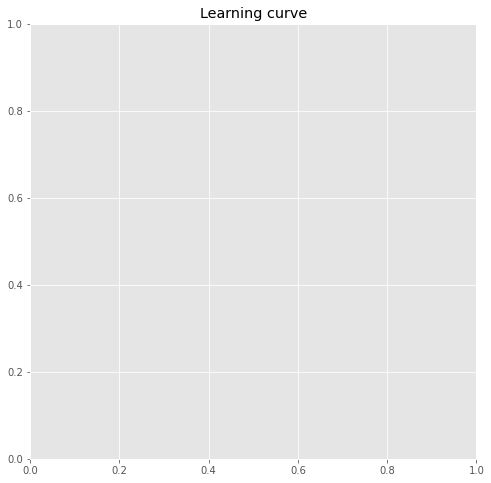

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss", color=sns.xkcd_rgb['greenish teal'])
plt.plot(results.history["val_loss"], label="val_loss", color=sns.xkcd_rgb['amber'])
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend()
# plt.grid(False)
plt.show()

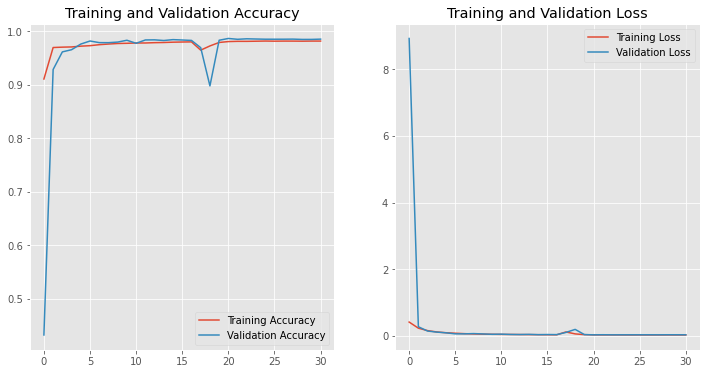

In [ ]:
acc = results.history['accuracy']
val_acc = results.history['val_accuracy']

loss = results.history['loss']
val_loss = results.history['val_loss']

epochs_range = range(31)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [46]:
import tensorflow 

In [51]:
model=tensorflow.keras.models.load_model("/content/drive/MyDrive/Soumaya - PFE/unet/saved_unet")

In [56]:
eval_results = model.evaluate(valid_gen, steps=STEP_SIZE_VALID, verbose=1)

23/23 [==============================] - 3s 88ms/step - loss: 0.0145 - accuracy: 0.9928


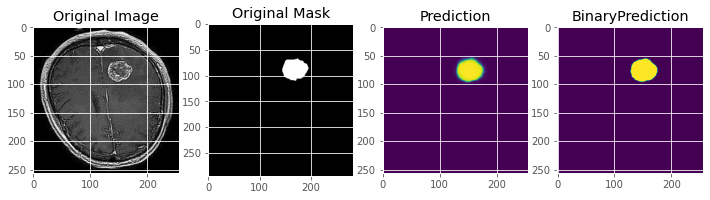

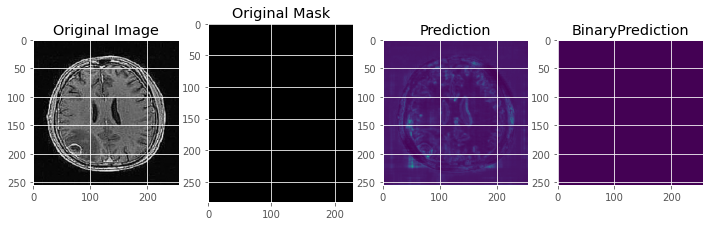

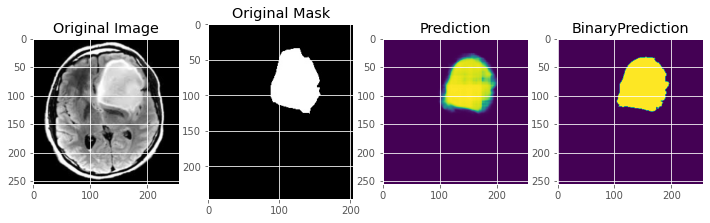

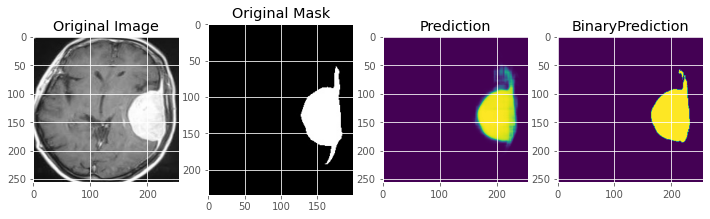

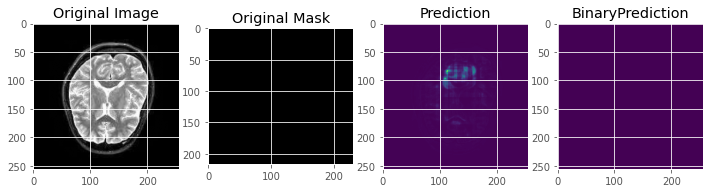

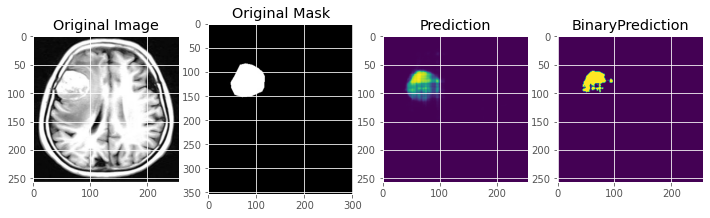

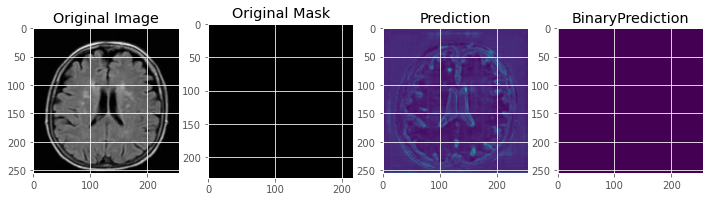

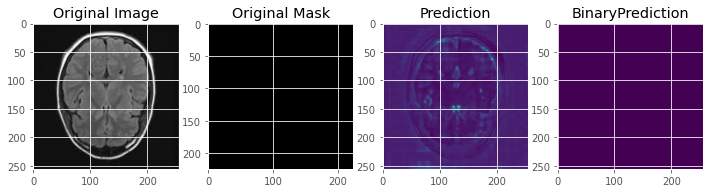

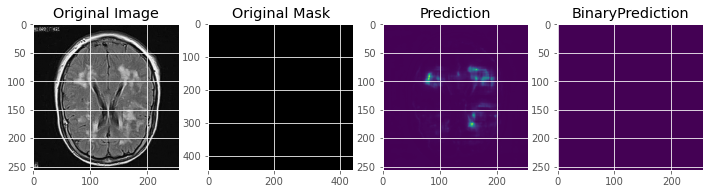

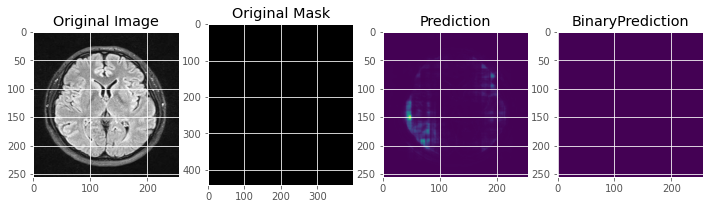

In [57]:
for i in range(10):
    idx = np.random.randint(0, len(imagePath_df))
    
    imagePath = os.path.join(DataPath, imagePath_df['directory'].iloc[idx], imagePath_df['images'].iloc[idx])
    maskPath = os.path.join(DataPath, imagePath_df['directory'].iloc[idx], imagePath_df['masks'].iloc[idx])
    
    image = cv2.imread(imagePath)
    mask = cv2.imread(maskPath)
    
    img = cv2.resize(image ,(ImgHieght, ImgWidth))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model1.predict(img)
   
    plt.figure(figsize=(12,12))
    plt.subplot(1,4,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,4,2)
    plt.imshow(mask)
    plt.title('Original Mask')
    plt.subplot(1,4,3)
    plt.imshow(np.squeeze(pred))
    plt.title('Prediction')
    plt.subplot(1,4,4)
    plt.imshow(np.squeeze(pred) > 0.5)
    plt.title('BinaryPrediction')
    plt.show()

In [ ]:
prob_pred = model.predict(valid_gen)
from sklearn import metrics
print('Accuracy score is :', np.round(metrics.accuracy_score(valid_gen, pred),4))
print('Precision score is :', np.round(metrics.precision_score(valid_gen, pred, average='weighted'),4))
print('Recall score is :', np.round(metrics.recall_score(valid_gen, pred, average='weighted'),4))
print('F1 Score is :', np.round(metrics.f1_score(valid_gen, pred, average='weighted'),4))
print('ROC AUC Score is :', np.round(metrics.roc_auc_score(valid_gen, pred,multi_class='ovo', average='weighted'),4))
print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(valid_gen, pred),4))

print('\t\tClassification Report:\n', metrics.classification_report(valid_gen, prob_pred))

TypeError: ignored

In [ ]:
# validate on test set
predictions = model.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

In [ ]:
import glob
%cd /content/drive/MyDrive
liste_fichiers = glob.glob("*_mask.jpg")
for i in liste_fichiers:
  path="/content/drive/MyDrive/"+i
  os.remove(path)